# AC209B Final Project
## Module E: Predicting COVID-19 Cases
- Austin Rochon
- Emily Xie
- Mark Lock

<hr style="height:2pt">

## Table of Contents

- [Introduction](#introduction)
- [Data Summary](#data_summary) 
- [Exploratory Data Analysis](#eda) 
- [Model Selection and Architecture](#model_selection)
- [Results](#results)
- [Appendix I: Data Collection and Cleaning](#data_collection)  
    - [COVID-19 Cases by State](#us_state_covid)  
    - [Google Search Data](#google_search)  
    - [Google Community Mobility Reports](#google_mobility)  
    - [IHME Social Distancing Data](#ihme_social_distancing)
    - [Weather](#weather)
    
 

<a id='introduction'></a>
## Introduction
***

In late 2019, a highly infectious novel coronavirus (SARS-CoV-2) emerged in the city of Wuhan, China. Within weeks, the virus and the disease it causes (COVID-19) had spread to multiple countries. On March 11, 2020, the World Health Organization officially declared the COVID-19 outbreak a pandemic, and as of the end of April 2020, there were over 3 million COVID-19 cases worldwide across over 200 countries and territories.

This project focuses on the impact of COVID-19 in the United States. In particular, we use a combination of Google search and mobility data, weather data, hospitalization and ICU numbers, and the dates in which state social distancing measures took effect to predict state-level COVID-19 cases in the US.

In [2]:
import pandas as pd
import pickle
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


<a id='data_summary'></a>
## Data Summary
***

For our response, we used a state-by-state COVID-19 cases dataset, curated by the New York times:
- **[COVID-19 Cases by State (Response)](https://github.com/nytimes/covid-19-data):** The NYT publishes national, state-level, and county-level COVID-19 case data to their github repository daily

To make predictions, we leveraged the following predictor data:
- **[Google Trends Search Data](https://trends.google.com/trends/?geo=US):** Through the Google Trends API, we collected search query data related to the coronavirus, and focused in particular on coronavirus symptom-based searches
- **[Google Community Mobility Reports](https://www.google.com/covid19/mobility/data_documentation.html?hl=en):** In March of 2020, Google began publishing "Community Mobility Reports", which tracked changes in activity from a pre-coronavirus baseline to now for countries across the world. It built these reports by collecting the location data tied to cell phones. In particular, it tracked changes in mobility for the following six categories: 
    - Retail & recreation
    - Grocery & pharmacy
    - Parks
    - Transit stations
    - Workplaces
    - Residential
- **[State Social Distancing Measures](http://www.healthdata.org/covid/faqs#social%20distancing):** The University of Washington's Institute for Health Metrics and Evaluation (IHME) has produced one of the most famous COVID-19 models. As part of its modeling, it incorporates state-wide social distancing measures. We've leveraged their data to determine whether and when a state put in place the following the following measures:
    - Educational facilities closed
    - Non-essential businesses ordered to close
    - People ordered to stay at home
    - Severe travel restrictions
    - Any gathering restrictions
    - Any business closures
- **[Hospitalization and ICU Data](https://covidtracking.com/data):** The Covid Tracking Project monitors hospitalization and ICU numbers for the states that report them. However, a big caveat for this data is that many states do not report these numbers
- **[Weather Data](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd):** The US National Oceanic and Atmospheric Association (NOAA) collects local climatological data for weather stations across the United States. We scraped this data to get temperature and humidity readings for all states in the US.



<a id='eda'></a>
## Exploratory Data Analysis
***
**US Cases by State**

In our initial EDA, we generated a bubble plot of the US, displaying states that were especially hard hit by COVID-19 (New York, Louisiana, and New Jersey), in terms of cases per capita. Rerunning our code depicts a grimmer picture, with new states such as Michigan and Illinois joining the originally hard hit ones.

In [70]:
from IPython.display import IFrame

IFrame(src='./images/US_covid_map.html', width=700, height=600)

**Coronavirus-Related Queries**

We began by investigating coronavirus-related Google searches. In particular, we sought to examine whether the following queries were associated with spikes in new cases:
- 'flu'
- 'shortness of breath'
- 'loss of smell'
- 'loss of taste'
- 'cough'
- 'fever'
- 'coronavirus testing near me'
- 'do i have coronavirus'
- 'covid testing center'
- 'chills'
- 'sore throat'
- 'fatigue'
- 'chest pain'

In [89]:
# load query data
queries = pickle.load( open( "./data/us_state_queries.p", "rb" ) )

# load case data
cases = pickle.load( open( "./data/us_state_cases_deaths.p", "rb" ) )

First, focusing on New York state, we can see how google search trends compare to the rise in COVID cases

In [118]:
# queries
s = "NY"
kw_list = list(queries.drop(["date", "abbrev", "days_since_20200101"], axis=1).columns)
s_queries = queries.loc[queries["abbrev"] == s]

# cases
s_cases = cases.loc[cases["abbrev"] == s]
s_cases["new_cases"] = s_cases["cases"].diff()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


First, let's look at the 4 queries with the highest volume

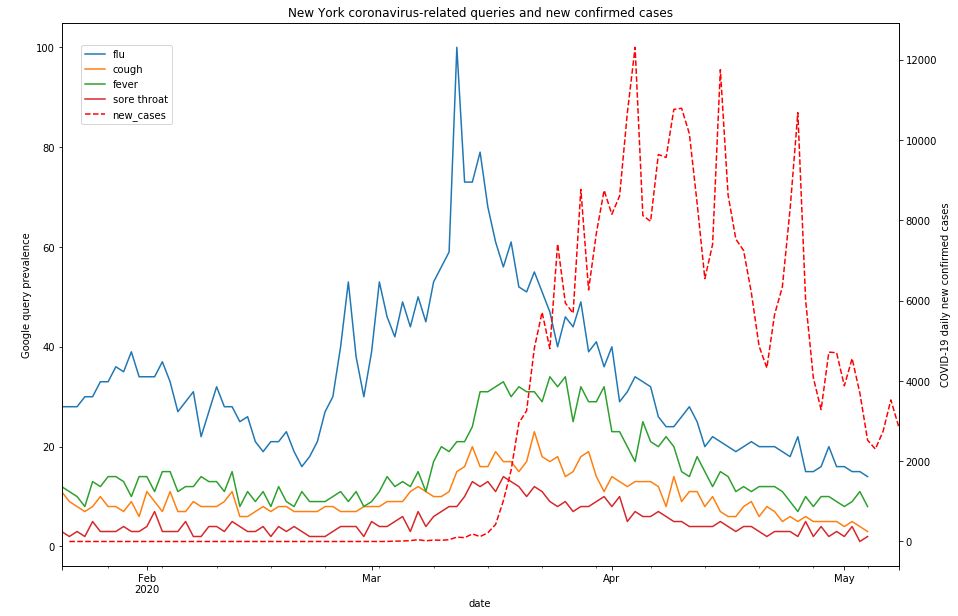

In [124]:
# now plot queries with confirmed cases
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

# queries
s_queries.plot(x="date", y=kw_list[0],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[4],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[5],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[10],  ax=ax1, legend=False)

ax2 = ax1.twinx()

# new cases
s_cases.plot(x="date", y="new_cases", ax=ax2, legend=False, color="r", linestyle='dashed')

# legend and titles
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.07,0.80))
ax1.set_title("New York coronavirus-related queries and new confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 daily new confirmed cases")
fig.savefig('./images/NY_covid_queries.png', format='png', dpi=300)
plt.show();

Now the next few. We won't plot them all because the charts get extremely noisy with many queries.

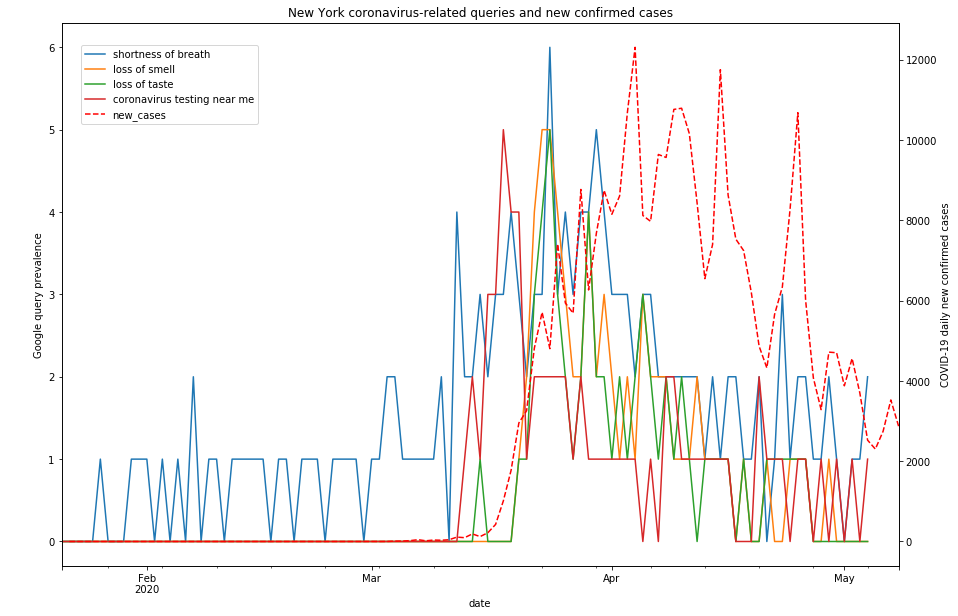

In [121]:
# now plot queries with confirmed cases
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

# queries
s_queries.plot(x="date", y=kw_list[1],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[2],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[3],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[6],  ax=ax1, legend=False)

ax2 = ax1.twinx()

# new cases
s_cases.plot(x="date", y="new_cases", ax=ax2, legend=False, color="r", linestyle='dashed')

# legend and titles
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.07,0.80))
ax1.set_title("New York coronavirus-related queries and new confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 daily new confirmed cases")
plt.show();

**Community Reports**

We also looked at community mobility reports. It might be worth looking at how mobility has changed over time since our initial EDA. As we can see below, after the precipitous drop in early April, retail and recreation have begun to slightly increase again, especially in Georgia, which, on May 1st, canceled its stay at home order. A similar trend is present in transit stations and workplaces.

In [67]:
# load mobility reports
mobility_us = pickle.load( open( "./data/us_state_mobility_data.p", "rb" ) )
mobility_us.head()

,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49


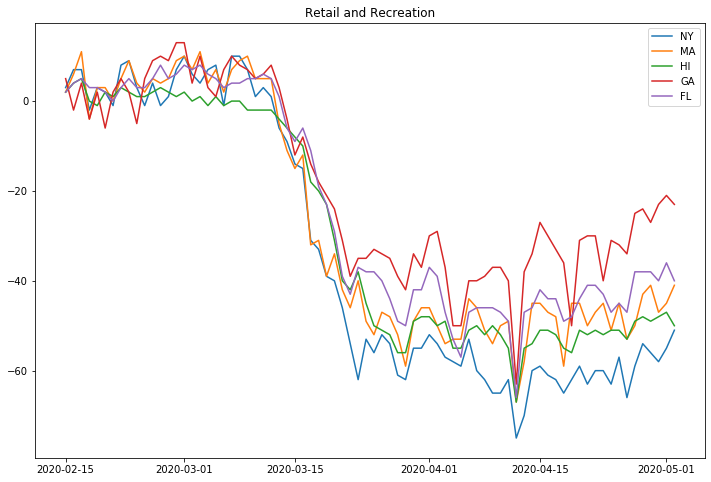

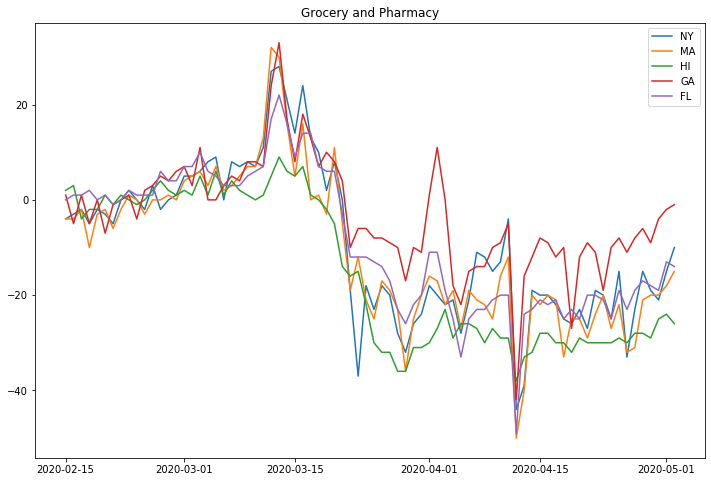

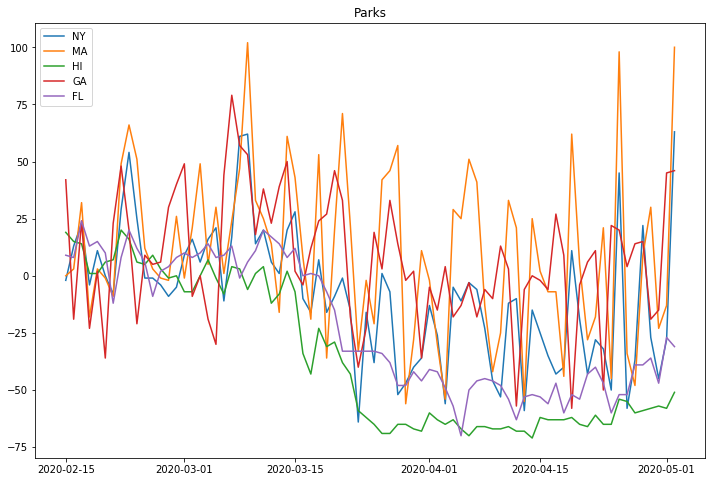

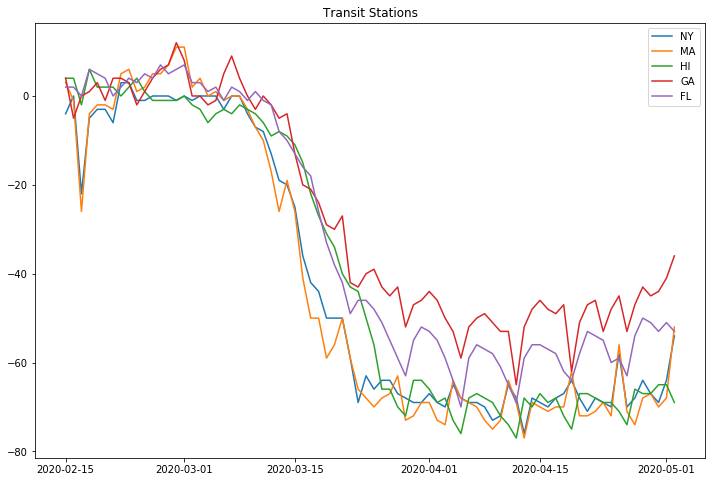

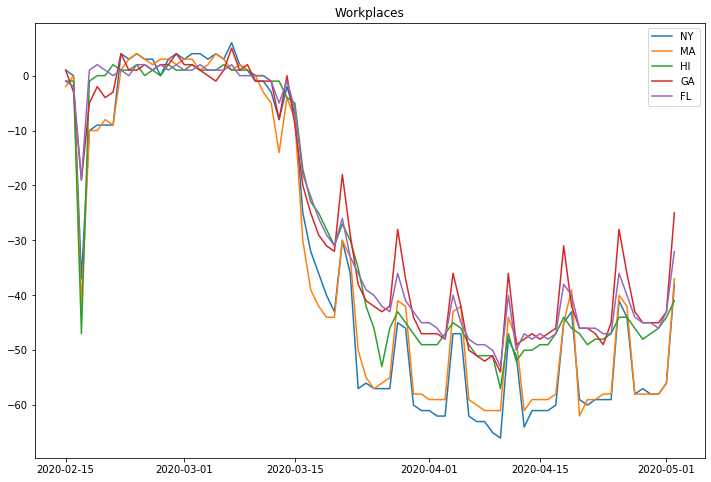

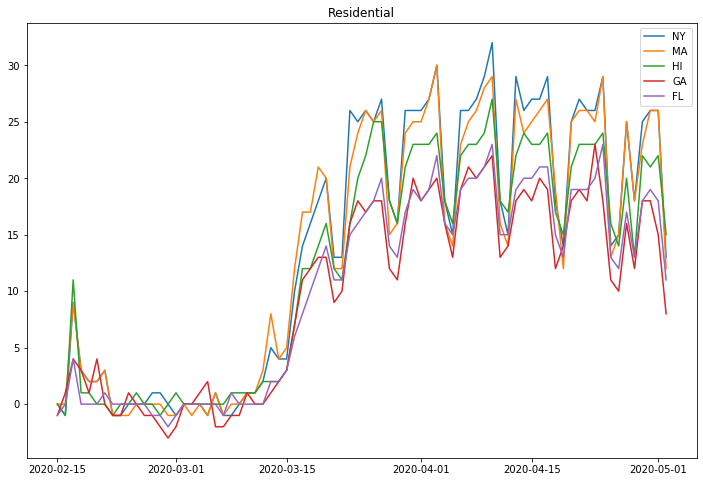

In [69]:
# subset of a few states
states = ["NY", "MA", "HI", "GA", "FL"]
mobility_sub = mobility_us.loc[mobility_us["abbrev"].isin(states)]


# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "retail_and_recreation_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Retail and Recreation")
    plt.legend();
    
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "grocery_and_pharmacy_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Grocery and Pharmacy")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "parks_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Parks")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "transit_stations_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Transit Stations")
    plt.legend();
    
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "workplaces_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Workplaces")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "residential_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Residential")
    plt.legend();

**Weather**

We also wanted to explore weather as a potential predictor, due to the speculation that the SARS-COV-2 virus is less viable for transmission in humid environments and high temperatures. 

In [24]:
# Import the response variable to perform EDA against.
response = pickle.load(open("./data/us_state_cases_deaths.p", "rb"))
response.head()

,date,state,fips,cases,deaths,abbrev,days_since_20200101
0,2020-01-21,Alabama,1,0,0,AL,20
1,2020-01-22,Alabama,1,0,0,AL,21
2,2020-01-23,Alabama,1,0,0,AL,22
3,2020-01-24,Alabama,1,0,0,AL,23
4,2020-01-25,Alabama,1,0,0,AL,24


In [7]:
weather_df = pickle.load(open("./data/daily_average_temp_by_state.p", "rb")) 
weather_df.head()

,date,state,average_temperature,abbrev,average_humidity,days_since_20200101
0,2020-01-01,Alabama,44.541667,AL,59.041667,0
1,2020-01-02,Alabama,52.654321,AL,94.580247,1
2,2020-01-03,Alabama,59.816327,AL,96.040816,2
3,2020-01-04,Alabama,52.139535,AL,78.511628,3
4,2020-01-05,Alabama,41.708333,AL,69.708333,4


Text(0.5, 1.0, 'Average Temperatures of States Since 1/1/2020')

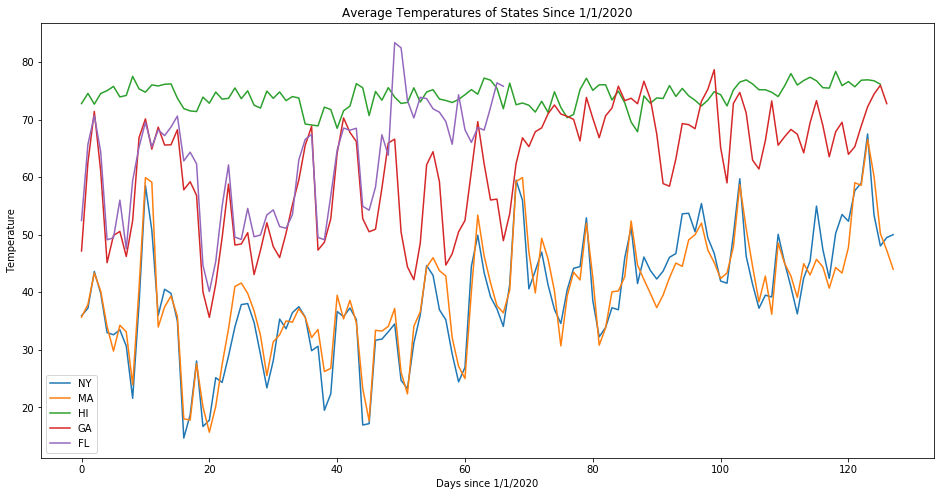

In [28]:
# Quick plot of the average temperatures across a few states to demonstrate what the data looks like.
plt.figure(figsize=(16, 8))
states = ["NY", "MA", "HI", "GA", "FL"]
for abbrev in states:
    average_temps = weather_df[weather_df["abbrev"] == abbrev]["average_temperature"]
    plt.plot(range(len(average_temps)), average_temps, label=abbrev)
    
plt.legend()
plt.xlabel("Days since 1/1/2020")
plt.ylabel("Temperature")
plt.title("Average Temperatures of States Since 1/1/2020")

We want to see if there are any correlations between temperature + humidity and deaths.
Given how varied states are in population, we'll import 2019 estimated census data for populations across the states.

And use the population in order to calculate the percentage of deaths due to COVID-19 as a way to make 
a fairer comparison from state to state.

Data obtained from:
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html#par_textimage_1574439295

In [31]:
import numpy as np
states_population_data = pd.read_csv("data/states_2019_estimated_population.csv")
states_population_data["population"] = states_population_data["population"].apply(lambda x: np.int64(x.replace(",", "")))
states_population_data.head()

,state,population
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


In [32]:
# Merge reponse and weather data into one PD for ease of use.
weather_cases = weather_df.merge(
    response, 
    left_on=["abbrev", "date"], 
    right_on=["abbrev", "date"]
).rename(
    columns={"state_x": "state", "days_since_20200101_x": "days_since_20200101"}
).drop(columns=["state_y", "days_since_20200101_y"]).merge(
    states_population_data,
    left_on="state",
    right_on="state",
).dropna(subset=["average_humidity"])
weather_cases.head()

,date,state,average_temperature,abbrev,average_humidity,days_since_20200101,fips,cases,deaths,population
0,2020-01-21,Alabama,31.000000,AL,57.291667,20,1,0,0,4903185
1,2020-01-22,Alabama,38.458333,AL,46.375000,21,1,0,0,4903185
2,2020-01-23,Alabama,43.354167,AL,89.416667,22,1,0,0,4903185
3,2020-01-24,Alabama,49.487805,AL,83.463415,23,1,0,0,4903185
4,2020-01-25,Alabama,42.166667,AL,71.888889,24,1,0,0,4903185


In [33]:
response_states = response["abbrev"].unique()

states_by_avg_temp = weather_cases.groupby(["state"]).agg({
    "average_temperature": "mean", 
    "average_humidity": "mean",
    "abbrev": "first",
    "cases": "max", # Since these figures are cumulative, just grab the largest
    "deaths": "max",
    "population": "max",
})
states_by_avg_temp["weighted_humidity_temp"] = (
    states_by_avg_temp["average_temperature"] * .80) + (states_by_avg_temp["average_humidity"] * .20
)

states_by_avg_temp = states_by_avg_temp.sort_values(by=["weighted_humidity_temp"], ascending=False)
states_by_avg_temp["deaths_percent"] = states_by_avg_temp["deaths"] / states_by_avg_temp["population"]

response_states_avg_temp = [x for x in states_by_avg_temp["abbrev"] if x in response_states]
    
coldest_states = response_states_avg_temp[0:5]
hottest_states = response_states_avg_temp[-6:-1]


We've added an extra column called "weighted_humidity_temp" in which we create a weighted sum of humidity and temperature. We sort the states in decreasing order of this metric.

In [35]:
print("Coldest / least humid states and death percentages:")
display(states_by_avg_temp[states_by_avg_temp["abbrev"].isin(coldest_states)])

print("Hottest / most humid states and death percentages:")
display(states_by_avg_temp[states_by_avg_temp["abbrev"].isin(hottest_states)])

Coldest / least humid states and death percentages:


,average_temperature,average_humidity,abbrev,cases,deaths,population,weighted_humidity_temp,deaths_percent
state,,,,,,,,
Hawaii,74.098544,70.266645,HI,616,17,1415872,73.332164,0.000012
Mississippi,66.229402,70.883702,MS,8424,374,2976149,67.160262,0.000126
Louisiana,63.143231,74.228962,LA,30652,2135,4648794,65.360377,0.000459
Florida,62.663637,71.201535,FL,37994,1538,21477737,64.371217,0.000072
Georgia,62.452800,71.490446,GA,29724,1309,10617423,64.260329,0.000123


Hottest / most humid states and death percentages:


,average_temperature,average_humidity,abbrev,cases,deaths,population,weighted_humidity_temp,deaths_percent
state,,,,,,,,
Vermont,31.792481,68.547146,VT,916,54,623989,39.143414,0.000087
North Dakota,27.708383,84.852818,ND,1371,31,762062,39.137270,0.000041
Wisconsin,28.842833,74.712823,WI,9215,374,5822434,38.016831,0.000064
New Hampshire,30.356930,68.413081,NH,2843,114,1359711,37.968160,0.000084
Minnesota,27.460580,68.763605,MN,9365,508,5639632,35.721185,0.000090


Certainly, just looking at the raw percentage of deaths in the warmest / most humid states vs the coldest / most arid states, there certainly appears to be a pattern. We can confirm this by plotting all of the states, arranged from most to least hot / humid.

/Users/Emily/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, '% of Pop. Deceased Due to COVID-19 (as of 2020-05-07)')

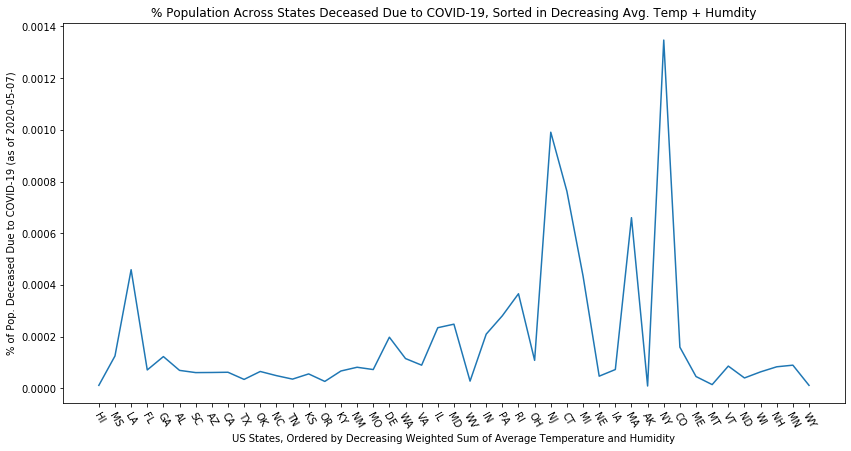

In [38]:
percent_pop_deaths_from_covid = states_by_avg_temp["deaths_percent"]
max_date = weather_cases["date"].max().date()

plt.figure(figsize=(14, 7))
plt.xticks(rotation=-60)
plt.plot(states_by_avg_temp["abbrev"], percent_pop_deaths_from_covid)

trendline = np.polyfit(range(len(states_by_avg_temp)), percent_deaths_from_covid, 50)
plt.title("% Population Across States Deceased Due to COVID-19, Sorted in Decreasing Avg. Temp + Humdity")
plt.xlabel("US States, Ordered by Decreasing Weighted Sum of Average Temperature and Humidity")
plt.ylabel(f"% of Pop. Deceased Due to COVID-19 (as of {max_date})")

The states are sorted from most humid and hot to least. While there are certainly other variables, there appears to be a noticeable correlation between higher percentage of cumuative deaths from COVID-19 in the population, and a drier / colder climate. 

<a id='model_selection'></a>
## Model Selection and Architecture
***

<a id='results'></a>
## Results
***

<a id='data_collection'></a>
## Appendix I: Data Collection and Cleaning
***

<a id='us_state_covid'></a>
### COVID-19 Cases by State
We'll start by fetching and cleaning our response data: COVID-19 cases by state

In [11]:
# fetch US state data from the NY Times github
covid_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")

# fetch US totals data and match formatting
covid_us_totals = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")
covid_us_totals["state"] = "United States"
covid_us_totals["fips"] = 0
covid_us_totals = covid_us_totals[["date", "state", "fips", "cases", "deaths"]]

# merge two dfs
covid_us = pd.concat([covid_us, covid_us_totals])

# transform date to datetime object
covid_us["date"] = pd.to_datetime(covid_us["date"])

covid_us

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
104,2020-05-04,United States,0,1186979,68843
105,2020-05-05,United States,0,1210686,71077
106,2020-05-06,United States,0,1235190,73785
107,2020-05-07,United States,0,1264001,75744


In [33]:
def impute_missing_dates(df):
    '''
    function that imputes cases and deaths data for missing 
    dates with 0. returned df should have same MIN_DATE and 
    MAX_DATE for all states.
    '''
    # set min values
    MIN_DATE = df["date"].min()
    MIN_CASES = 0
    MIN_DEATHS = 0
    
    # iterate through all states
    imputed_data = []    
    for state in df["state"].unique():
        # build list of missing dates
        # https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
        sdate = MIN_DATE
        edate = df.loc[df["state"] == state]["date"].min()
        delta = edate - sdate 

        # iterate through all missing dates and impute case and 
        # death data
        for i in range(delta.days):
            day = sdate + datetime.timedelta(days=i)
            imputed_data.append({"date": day,
                                 "state": state,
                                 "fips": df.loc[df["state"]==state].iloc[0]["fips"],
                                 "cases": MIN_CASES,
                                 "deaths": MIN_DEATHS})

    # final cleanup
    new_df = pd.concat([pd.DataFrame(imputed_data), df])
    new_df = new_df.sort_values(by=["state", "date"]).reset_index().drop("index", axis=1)
    
    return new_df
    

def days_since_20200101(df):
    '''
    Creates a new column which measures the number of days that 
    a given observation is from 20200101 (which will be our 
    baseline date)
    '''
    # create days_since_20200101 col
    START_DATE = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
    df["days_since_20200101"] = (df["date"] - START_DATE).dt.days
    
    return df
    
    
# map state abbreviation
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'United States': 'USA'
}

states = list(states_dict.values())

In [13]:
# clean data by imputing missing dates and mapping abbreviations
covid_us_cleaned = impute_missing_dates(covid_us)
covid_us_cleaned["abbrev"] = covid_us_cleaned["state"].map(states_dict)

# create days_since_20200101 col
covid_us_cleaned = days_since_20200101(covid_us_cleaned)
covid_us_cleaned

,date,state,fips,cases,deaths,abbrev,days_since_20200101
0,2020-01-21,Alabama,1,0,0,AL,20
1,2020-01-22,Alabama,1,0,0,AL,21
2,2020-01-23,Alabama,1,0,0,AL,22
3,2020-01-24,Alabama,1,0,0,AL,23
4,2020-01-25,Alabama,1,0,0,AL,24
...,...,...,...,...,...,...,...
6099,2020-05-04,Wyoming,56,596,7,WY,124
6100,2020-05-05,Wyoming,56,604,7,WY,125
6101,2020-05-06,Wyoming,56,631,7,WY,126
6102,2020-05-07,Wyoming,56,635,7,WY,127


<a id='google_search'></a>
### Google COVID-19 Searches

Next, we collected Google search data related to COVID-19. We started by curating a list of Google search queries that we thought could be predictive of coronavirus cases. To extract the Google query data, we used [pytrends](https://github.com/GeneralMills/pytrends) a library that allows you to query the GoogleTrends API for search data.

In [14]:
import pytrends
from pytrends.request import TrendReq

# connect 
pyt = TrendReq(hl='en-US', tz=300)

We started by fetching a list of queries related to "coronavirus symptoms"

In [15]:
kw_list = ["coronavirus symptoms"]
now = datetime.datetime.now().strftime("%Y-%m-%d")
time_frame = f'''2020-01-01 {now}'''
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
pyt.related_queries()[kw_list[0]]["rising"]

,query,value
0,the coronavirus,989350
1,the symptoms of the coronavirus,675550
2,the symptoms of coronavirus,663400
3,corona symptoms,490450
4,corona,488550
5,what are coronavirus symptoms,413900
6,corona virus,354150
7,corona virus symptoms,345900
8,what are symptoms of coronavirus,343550
9,what are the coronavirus symptoms,325700


The final query list we landed on was:
- 'flu'
- 'shortness of breath'
- 'loss of smell'
- 'loss of taste'
- 'cough'
- 'fever'
- 'coronavirus testing near me'
- 'do i have coronavirus'
- 'covid testing center'
- 'chills'
- 'sore throat'
- 'fatigue'
- 'chest pain'

Note: the Google Trends API only allows you to compare 5 queries at a time. Thus, we used our highest volume query, `flu`, and included it in several calls as a baseline.

In [ ]:
def fetch_query_data(kw_list):
    '''
    Fetches Google search data for a list of keywords
    for all states, one at a time. We do it one at a time
    so that the search data is relative to the timing of 
    each state
    '''
    
    # instantiate state list and empty df to store results
    states = list(states_dict.values())
    state_queries = pd.DataFrame(columns = ["date", "abbrev"] + kw_list)
    state_queries = state_queries.set_index("date")

    print(f"Fetching data for the following queries: {kw_list}")
    # fetch all queries for each state in date range
    for state in states:
        if state == "USA":
            geo = "US"
        else:
            geo = f"US-{state}"
        try:
            pyt.build_payload(kw_list, cat=0, timeframe=f"2020-01-1 {now}", geo=geo, gprop='')
        except:
            print(f"NOT FOUND: {state}")
            continue
        interest = pyt.interest_over_time().reset_index()
        interest["abbrev"] = state
        state_queries = pd.concat([interest, state_queries])

    # clean data types
    state_queries["date"] = pd.to_datetime(state_queries["date"])
    state_queries[kw_list] = state_queries[kw_list].apply(pd.to_numeric)
    state_queries = state_queries[["date", "abbrev"] + kw_list]
    
    # sort
    state_queries = state_queries.sort_values(by=["abbrev", "date"])
    
    return(state_queries)

In [ ]:
# build queries 5 at a time, benchmark is flu
# start queries
benchmark = "flu"
kw_list = [benchmark, "shortness of breath", "loss of smell", "loss of taste", "cough"]
queries_master = fetch_query_data(kw_list)

In [ ]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "fever", "coronavirus testing near me", "do i have coronavirus", 
           "covid testing center"]
queries = fetch_query_data(kw_list)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])

In [ ]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "chills", "sore throat", "fatigue", "chest pain"]
queries = fetch_query_data(kw_list)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])



<a id='google_mobility'></a>
### Google Community Mobility Reports

In [26]:
# load mobility reports
mobility = pd.read_csv("./data/raw_data/Global_Mobility_Report.csv")
mobility.head()


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [27]:
# US data - condense to state level
mobility_us = mobility.loc[(mobility["country_region_code"] == "US") & (pd.isnull(mobility["sub_region_2"]))]

# subset columns
mobility_us = mobility_us[["date", "sub_region_1", "retail_and_recreation_percent_change_from_baseline", 
                           "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline",
                           "transit_stations_percent_change_from_baseline", "workplaces_percent_change_from_baseline",
                           "residential_percent_change_from_baseline"]]

# rename state column
mobility_us = mobility_us.rename({'sub_region_1': 'state'}, axis=1)

# fetch abbrevation
mobility_us["abbrev"] = mobility_us["state"].map(states_dict)

# fill USA totals with appropriate labels
mobility_us["state"] = mobility_us["state"].fillna(value="United States")
mobility_us["abbrev"] = mobility_us["abbrev"].fillna(value="USA")

# convert date to datetime obj
mobility_us["date"] = pd.to_datetime(mobility_us["date"])

mobility_us.head()


,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA


In [28]:
# add days since 20200101
mobility_us = days_since_20200101(mobility_us)
mobility_us.head()

,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49


<a id='ihme_social_distancing'></a>
### IHME: social distancing measures

The following [mitigation/social distancing](http://www.healthdata.org/covid/faqs#social%20distancing) measures were collected by IHME and incoporated into their model:

- **Educational facilities closed:** All levels of educational instruction (primary, secondary, and higher education) are required to implement distance learning and are closed for in-person teaching activities.
 
- **Non-essential businesses ordered to close:** Only locally defined “essential services” are in operation. Typically, this results in closure of public spaces such as stadiums, cinemas, shopping malls, museums, and playgrounds. It also includes restrictions on bars and restaurants (they may provide take-away and delivery services only), closure of general retail stores, and services (like nail salons, hair salons, and barber shops) where appropriate social distancing measures are not practical. There is an enforceable consequence for non-compliance such as fines or prosecution.
 
- **People ordered to stay at home:** All individuals are ordered to stay at home unless traveling to essential services. Physical contact is only allowed between residents of the same household. Exercise may be permitted, as a solitary, distanced exercise, or with members of the same household. There is an enforceable consequence for non-compliance such as fines or prosecution.
 
- **Severe travel restrictions:** Location borders are closed to all incoming traffic except for those in provision of essential services and returning residents isolated in foreign territories. Automobile travel is restricted to accessing and working at essential services. Public transit is closed.
 
- **Any gathering restrictions:** Mandatory restrictions on gatherings of individuals of any number are in place. These can apply to public and private gatherings.
 
- **Any business closures:** The mandatory closure of any businesses is in effect. These restrictions need not apply to all businesses but can apply to just a specific subset (like bars and restaurants)


For our purposes, we took the measure start/end dates and transformed them into a time series for each state, with a `1` indicating that a measure was in place for that date, and a `0` indicating that it was not. Here are some definitions for how we dealt with special cases:
- *Measure never activated:* IHME designates measures that never were enforced in a given state with a NULL for that measure's start date. We represented these cases with values of `0` for all dates
- *Measure doesn't have an end date:* Some measures that have been put in place do not have an end date. For those cases, IHME assumes an end date of `2020-08-04`. We did the same. That is, the measure will have a `1` for all days until `2020-08-04`. In our case, the master dataset only extended to `2020-05-04`, so we stopped there



In [29]:
# load ihme data
ihme_summary = pd.read_csv("./data/raw_data/summary_stats_all_locs.csv")

# fetch only US states
ihme_summary = ihme_summary.loc[ihme_summary["location_name"].isin(list(states_dict.keys()))]
ihme_summary.head()

,location_name,peak_bed_day_lower,peak_bed_day_upper,peak_icu_bed_day_lower,peak_icu_bed_day_upper,peak_vent_day_lower,peak_vent_day_upper,peak_bed_day_mean,peak_icu_bed_day_mean,peak_vent_day_mean,...,any_gathering_restrict_start_date,educational_fac_start_date,stay_home_start_date,travel_limit_start_date,all_non-ess_business_end_date,any_business_end_date,any_gathering_restrict_end_date,educational_fac_end_date,stay_home_end_date,travel_limit_end_date
1,Alabama,2020-04-28,2020-07-06,2020-04-28,2020-07-05,2020-04-28,2020-07-04,2020-06-25,2020-06-26,2020-06-26,...,2020-03-19,2020-03-19,2020-04-04,NaN,2020-04-30,NaN,NaN,NaN,2020-04-30,NaN
2,Alaska,2020-04-02,2020-04-02,2020-04-05,2020-04-05,2020-04-05,2020-04-05,2020-04-02,2020-04-05,2020-04-05,...,2020-03-24,2020-03-16,2020-03-28,2020-03-28,2020-04-24,NaN,NaN,NaN,2020-04-24,2020-04-24
6,Arizona,2020-04-18,2020-05-26,2020-04-19,2020-05-27,2020-04-19,2020-05-26,2020-05-05,2020-05-10,2020-05-08,...,2020-03-30,2020-03-16,2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arkansas,2020-04-26,2020-06-04,2020-04-27,2020-06-05,2020-04-27,2020-06-05,2020-04-30,2020-05-06,2020-04-29,...,2020-03-27,2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,California,2020-04-19,2020-05-14,2020-04-23,2020-05-13,2020-04-22,2020-05-13,2020-04-30,2020-04-30,2020-04-30,...,2020-03-11,2020-03-19,2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# create dataframe with just mitigation measures
keeps = ['location_name', 'all_non-ess_business_start_date', 'any_business_start_date',
              'any_gathering_restrict_start_date', 'educational_fac_start_date',
              'stay_home_start_date', 'travel_limit_start_date',
              'all_non-ess_business_end_date', 'any_business_end_date',
              'any_gathering_restrict_end_date', 'educational_fac_end_date',
              'stay_home_end_date', 'travel_limit_end_date']
mitigation = ihme_summary[keeps]

# per IHME, if a mitigation order has a start date, but no end date, we will
# assume that it is carried through aug 4
ASSUMED_END_DATE = "2020-08-04"
mitigation_measures = ["all_non-ess_business", "any_business", "any_gathering_restrict", "educational_fac",
                       "stay_home", "travel_limit"]

# clean state label fields
mitigation = mitigation.rename({'location_name': 'state'}, axis=1)
mitigation["abbrev"] = mitigation["state"].map(states_dict)

# impute IHME assumed end dates
for measure in mitigation_measures:
    mitigation.loc[(pd.notnull(mitigation[f"{measure}_start_date"])) & 
               (pd.isnull(mitigation[f"{measure}_end_date"]))
               , f"{measure}_end_date"] = ASSUMED_END_DATE

# convert dates to datetime
mitigation[keeps[1:]] = pd.to_datetime(mitigation[keeps[1:]].stack(), errors="coerce").unstack()
display(mitigation.head())


,state,all_non-ess_business_start_date,any_business_start_date,any_gathering_restrict_start_date,educational_fac_start_date,stay_home_start_date,travel_limit_start_date,all_non-ess_business_end_date,any_business_end_date,any_gathering_restrict_end_date,educational_fac_end_date,stay_home_end_date,travel_limit_end_date,abbrev
1,Alabama,2020-03-28,2020-03-19,2020-03-19,2020-03-19,2020-04-04,NaT,2020-04-30,2020-08-04,2020-08-04,2020-08-04,2020-04-30,NaT,AL
2,Alaska,2020-03-28,2020-03-17,2020-03-24,2020-03-16,2020-03-28,2020-03-28,2020-04-24,2020-08-04,2020-08-04,2020-08-04,2020-04-24,2020-04-24,AK
6,Arizona,NaT,NaT,2020-03-30,2020-03-16,2020-03-30,NaT,NaT,NaT,2020-08-04,2020-08-04,2020-08-04,NaT,AZ
7,Arkansas,NaT,2020-03-19,2020-03-27,2020-03-17,NaT,NaT,NaT,2020-08-04,2020-08-04,2020-08-04,NaT,NaT,AR
22,California,2020-03-19,2020-03-19,2020-03-11,2020-03-19,2020-03-19,NaT,2020-08-04,2020-08-04,2020-08-04,2020-08-04,2020-08-04,NaT,CA


In [31]:
def build_mitigation_time_series(state_abbrev):
    """
    Takes a start and end date for a given measure and converts it
    to a time series of 0 and 1 indicating whether the measure was
    in place for that day
    """
    
    # build standalone df of state mitigation dates
    state_mitigation = mitigation.loc[mitigation["abbrev"] == state_abbrev]

    # empty df with state and dates of interest
    state_dates = queries_master.loc[queries_master["abbrev"] == state_abbrev][["date", "abbrev"]]
    state_dates["date"] = pd.to_datetime(state_dates["date"])

    # generate time series of mitigation measures
    for measure in mitigation_measures:
        state_dates[measure] = (
            (state_dates["date"] >= state_mitigation[f"{measure}_start_date"].values[0]) & 
            (state_dates["date"] <= state_mitigation[f"{measure}_end_date"].values[0])).astype(int)
        
    return state_dates

In [34]:
# empty df
hi = build_mitigation_time_series("HI")
state_mitigation_measures = pd.DataFrame(columns = hi.columns)

# loop through all states
for state in states:
    try:
        state_mit = build_mitigation_time_series(state)
    except:
        print(f"NOT FOUND: {state}")
    state_mitigation_measures = pd.concat([state_mitigation_measures, state_mit])
    
state_mitigation_measures.head()    

NOT FOUND: AS
NOT FOUND: GU
NOT FOUND: MP
NOT FOUND: VI
NOT FOUND: USA


,date,abbrev,all_non-ess_business,any_business,any_gathering_restrict,educational_fac,stay_home,travel_limit
125,2020-01-01,AL,0,0,0,0,0,0
126,2020-01-02,AL,0,0,0,0,0,0
127,2020-01-03,AL,0,0,0,0,0,0
128,2020-01-04,AL,0,0,0,0,0,0
129,2020-01-05,AL,0,0,0,0,0,0


<a id='weather'></a>
### Weather Data

Weather data from www.ncdc.noaa.gov has been collected from their databases and incorporated into our experiments. We aimed to collect data on the daily average humidity and temperature across each state. However, because there were multiple observation towers per state, we elected to choose just one (and in some cases, two––namely when a state is partcularly large or when an initial selected dataset was found to be incomplete) to represent the state and averaged them.

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import sys
# Append path to import helper modules
sys.path.append("../")


import pandas as pd
import pickle
import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from utilities import states_to_abbrev, abbrev_to_states, days_since_20200101

We wanted to standardize the format across our peredictors so that it reflects that of the mobility data, in which there is a a column called "state", along with a corresponding "abbrev", as well as a "days_since_20200101" and "date" column. The final output entails rows that correspond to a weather observation for a given day in a month for a state.

So, let's import the mobility data (wrangled above) to once again remind ourselves of what our data should look like:

In [8]:
mobility_data = pickle.load(open("data/us_state_mobility_data.p", "rb"))
required_states = mobility_data["abbrev"].unique()

# See the states that are required.
print(required_states)
display(mobility_data)

['USA' 'AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID'
 'IL' 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT'
 'NE' 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC'
 'SD' 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49
...,...,...,...,...,...,...,...,...,...,...
304088,2020-04-28,Wyoming,-21.0,1.0,23.0,-7.0,-33.0,5.0,WY,118
304089,2020-04-29,Wyoming,-18.0,3.0,76.0,-3.0,-34.0,11.0,WY,119
304090,2020-04-30,Wyoming,-20.0,1.0,51.0,-1.0,-35.0,12.0,WY,120
304091,2020-05-01,Wyoming,-20.0,3.0,50.0,5.0,-31.0,12.0,WY,121


Cleaning, processing, and concatenating the raw observation data:

In [16]:
"""
First, we'll concatenate all the government weather data collected from together.
"""
RAW_DATA_DIR = "data/raw_data/"
csv_data = []

for i in range(1, 8):
    csv_data.append(pd.read_csv(f"{RAW_DATA_DIR}state_weather_{i}.csv"))
    

In [17]:
"""
There are many columns here for temperature, but after a quick Google search, it appears that the "dryBulb" 
temperature is the meaningful one––what we understand as the temperature.
"""
columns = csv_data[0].columns
keep = set(["STATION", "DailyAverageDryBulbTemperature", "HourlyRelativeHumidity", "HourlyDryBulbTemperature"])
columns_to_remove = set(columns).difference(keep)


In [18]:
"""
Now, let's investigate what one of these raw weather CSVs look like:
"""
csv_data[0].head()

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72216013869,2020-01-01T00:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
1,72216013869,2020-01-01T01:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
2,72216013869,2020-01-01T02:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
3,72216013869,2020-01-01T03:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
4,72216013869,2020-01-01T04:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31


In [19]:
"""
Let's standardize some of these datatypes, especially since the datatypes were
inconsistent from  CSV to CSV.
"""
states_weather = pd.concat(csv_data, axis=0)
states_weather = states_weather.rename(columns={"STATION": "station_id"})
states_weather["date"] = pd.to_datetime(states_weather["DATE"], infer_datetime_format=True)
states_weather = states_weather.drop(columns=columns_to_remove)

# An entire dataset for Utah is problematic, so we must drop it.
states_weather = states_weather[states_weather["station_id"] != "A0001603036"]

states_weather["HourlyDryBulbTemperature"] = pd.to_numeric(
    states_weather["HourlyDryBulbTemperature"], errors="coerce"
)
states_weather["HourlyRelativeHumidity"] = pd.to_numeric(
    states_weather["HourlyRelativeHumidity"], errors="coerce"
)
states_weather = states_weather.dropna(subset=["HourlyDryBulbTemperature"])

display(states_weather)

,station_id,DailyAverageDryBulbTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,date
0,72216013869,NaN,40.0,83.0,2020-01-01 00:53:00
1,72216013869,NaN,39.0,82.0,2020-01-01 01:53:00
2,72216013869,NaN,37.0,86.0,2020-01-01 02:53:00
3,72216013869,NaN,37.0,86.0,2020-01-01 03:53:00
4,72216013869,NaN,36.0,89.0,2020-01-01 04:53:00
...,...,...,...,...,...
36257,72365023050,NaN,77.0,17.0,2020-05-06 19:52:00
36258,72365023050,NaN,73.0,19.0,2020-05-06 20:52:00
36259,72365023050,NaN,74.0,18.0,2020-05-06 21:52:00
36260,72365023050,NaN,73.0,18.0,2020-05-06 22:52:00


Since the raw observation data does not directly tie each observation to a state, we must do this ourselves. The NOAA site had a metadata file listing all of the worldwide stations, and their wban_id, along with the station ID. Concating these two fields together will bring us the station ID.

In [20]:
def extract_station_metadata():
    """
    In order to associate each of these measurements to a state, we must look to the
    station metadata.
    
    Unfortunately, the text file for the station metadata is formatted by character start number,
    so we can't just read it with a numpy csv parser or panda.read_csv and a basic delimiter. 

    Since this document entails all weather stations world-wide, we'll want to extract 
    station_ids for US states only. The station_ids found in the observation data
    are a concatenation of the wban_id and the station meta id, so we'll do that here.
    """
    station_df = []
    station_ids = open("data/raw_data/station_metadata.txt", "r")

    # state start index
    ss_index = 47
    wban_index = 7
    for i, line in enumerate(station_ids):
        # skip header
        if i == 0:
            continue
        state = line[ss_index: ss_index + 3].strip()
        if state.isspace():
            continue
        else:
            # It's a US state. Start parsing.
            wban_id = line[wban_index: wban_index + 6].strip()
            station_meta = line[0:7].strip()
            # Because why not?
            lattitude = line[57:66].strip()
            longitude = line[65:75].strip()
            elevation = line[74:82].strip()
            station_name = line[13:43].strip()
            station_id = f"{station_meta}{wban_id}"
            try:
                # The weather data has the station ID as an integer. 
                # Data types must match up in the join, so throw out anything that's not
                # castable to an int.
                station_id = int(station_id)
            except:
                continue
            row = {
                "wban_id": int(wban_id),
                "state": state,
                "station_meta": station_meta,
                "lattitude": lattitude,
                "longitude": longitude,
                "elevation": elevation,
                "station_name": station_name,
                "station_id": station_id
            }
            station_df.append(row)
    result = pd.DataFrame(station_df)
    return result

station_df = extract_station_metadata()
display(station_df)

,wban_id,state,station_meta,lattitude,longitude,elevation,station_name,station_id
0,99999,,007018,+00.000 +,+000.000 +,+7018.0,WXPOD 7018,701899999
1,99999,,007026,+00.000 +,+000.000 +,+7026.0,WXPOD 7026,702699999
2,99999,,007070,+00.000 +,+000.000 +,+7070.0,WXPOD 7070,707099999
3,99999,,008260,+00.000 +,+000.000 +,+0000.0,WXPOD8270,826099999
4,99999,,008268,+32.950 +,+065.567 +,+1156.7,WXPOD8278,826899999
...,...,...,...,...,...,...,...,...
29703,96405,AK,999999,+60.473 -,-145.354 +,+0025.3,CORDOVA 14 ESE,99999996405
29704,96406,AK,999999,+64.502 -,-154.130 +,+0078.9,RUBY 44 ESE,99999996406
29705,96407,AK,999999,+66.562 -,-159.004 +,+0006.7,SELAWIK 28 E,99999996407
29706,96408,AK,999999,+63.452 -,-150.875 +,+0678.2,DENALI 27 N,99999996408


In [21]:
# Now, we'll finally merge the station and state weather together into a dataframe
states_df = states_weather.merge(station_df, left_on="station_id", right_on="station_id")
display(states_df)

,station_id,DailyAverageDryBulbTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,date,wban_id,state,station_meta,lattitude,longitude,elevation,station_name
0,72216013869,NaN,40.0,83.0,2020-01-01 00:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
1,72216013869,NaN,39.0,82.0,2020-01-01 01:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
2,72216013869,NaN,37.0,86.0,2020-01-01 02:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
3,72216013869,NaN,37.0,86.0,2020-01-01 03:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
4,72216013869,NaN,36.0,89.0,2020-01-01 04:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
...,...,...,...,...,...,...,...,...,...,...,...,...
492361,72365023050,NaN,77.0,17.0,2020-05-06 19:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP
492362,72365023050,NaN,73.0,19.0,2020-05-06 20:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP
492363,72365023050,NaN,74.0,18.0,2020-05-06 21:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP
492364,72365023050,NaN,73.0,18.0,2020-05-06 22:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP


In [22]:
"""
Now, let's check to be sure there's data for all states to determine if we are missing
any data for states.
"""
grouped_states = states_df.groupby(["station_name", "station_id", "state"]).agg(
    {"station_name": "first", "station_id": "first", "state": "first"}
).reset_index(drop=True)

states_list = set(grouped_states["state"].values)


missing_states = set(required_states).difference(set(states_list))
ms_full = [abbrev_to_states[x] for x in list(missing_states)]
print(ms_full)

['District of Columbia', 'United States']


Above, we see that we are missing data for the District of Columbia and the "United States", as specified in the mobility data. 

Given that is no weather dataset specifically for DC available through NOAA, so we'll simply use data from nearby Maryland. Meanwhile, the "United States" as a state represents aggregate calculation across all states. We'll impute this data later on.

But first, since these observations are only an hourly basis (we want daily), let's group all of them into buckets for a month for a state for a day.

In [30]:
weather_df = states_df.groupby(
    ["state", states_df["date"].dt.year, states_df["date"].dt.month, states_df["date"].dt.day]
).agg({
    "state": "first",
    "date": "first",
    "HourlyDryBulbTemperature": "mean",
     # As some of the hourly relative humidities are NaAN values,
    # Let's agggregate them into a list, and then we'll run an np.nanmean on them
    "HourlyRelativeHumidity": lambda x: list(x), 
}).rename(columns={"HourlyDryBulbTemperature": "average_temperature"}).reset_index(drop=True)

weather_df["abbrev"] = weather_df["state"]
weather_df["state"] = weather_df["state"].apply(lambda x: abbrev_to_states[x])
weather_df["date"] = weather_df["date"].dt.date

In [31]:
# Make the average humidity title slug case, and average them, discounting NaNs
weather_df["average_humidity"] = weather_df["HourlyRelativeHumidity"].apply(
    lambda x: np.nanmean(np.array(x))
)
weather_df = weather_df.drop(columns=["HourlyRelativeHumidity"])
print("Below is the average daily humidity and temperature for each state for every month")
display(weather_df)

Below is the average daily humidity and temperature for each state for every month


,state,date,average_temperature,abbrev,average_humidity
0,Alaska,2020-01-01,21.271028,AK,79.766355
1,Alaska,2020-01-02,12.590909,AK,80.386364
2,Alaska,2020-01-03,11.866667,AK,83.986667
3,Alaska,2020-01-04,14.600000,AK,85.381818
4,Alaska,2020-01-05,10.089286,AK,78.035714
...,...,...,...,...,...
6818,Wyoming,2020-05-02,42.972973,WY,74.567568
6819,Wyoming,2020-05-03,44.666667,WY,62.111111
6820,Wyoming,2020-05-04,42.458333,WY,32.958333
6821,Wyoming,2020-05-05,42.500000,WY,42.583333


In [32]:
"""
Since we require a consistent time-series data with no missing dates,
let's write a method to check any data that we might be missing:
"""
def check_missing_dates(df):
    missing_dates = []
    min_date = df["date"].min()
    for abbrev in required_states:
        if abbrev == "DC" or abbrev == "USA":
            continue
        # Get minimum and maximum date per state.
        max_date = df[df["abbrev"] == abbrev]["date"].max()
        missing_dates_per_state = pd.date_range(start=min_date, end=max_date).difference(
            df[df["abbrev"] == abbrev]["date"].values
        )
        
        if not missing_dates_per_state.values.size == 0:
            print(f"For {abbrev}, missing:")
            print(missing_dates_per_state.values)
            missing_dates.append((abbrev, missing_dates_per_state.values))
    return missing_dates

missing_dates = check_missing_dates(weather_df)

For AZ, missing:
['2020-04-13T00:00:00.000000000']
For HI, missing:
['2020-03-29T00:00:00.000000000']
For TX, missing:
['2020-01-25T00:00:00.000000000']


For some reason, there are a couple of missing days of data for Arizona, Hawaii, and Texas. Let's impute them with some precision, using the data from the day before.

In [33]:
def impute_missing_dates_sparse(missing_dates, df):
    """
    Imputes a couple of missing dates in the middle 
    of the dataset using data from the day prior.
    """
    df = df.copy()
    missing_data = []
    for abbrev, date in missing_dates:
        # Converting back and forth between np.datetime64 and
        # datetime.datetime
        datec = pd.DatetimeIndex(date)
        datec = datetime.datetime(
            year=datec.year.values[0], 
            month=datec.month.values[0], 
            day=datec.day.values[0]
        ).date()
        
        prev_date = pd.DatetimeIndex([date[0] - np.timedelta64(1, "D")])


        # Now convert to datetime
        prev_date = datetime.datetime(
            year=prev_date.year.values[0], 
            month=prev_date.month.values[0], 
            day=prev_date.day.values[0]
        ).date()
        

        prev_row = df[np.logical_and(df["abbrev"] == abbrev, df["date"] == prev_date)]
        data = {
            "date": datec,
            "state": abbrev_to_states[abbrev],
            "abbrev": abbrev,
            "average_temperature": prev_row["average_temperature"].values[0],
            "average_humidity": prev_row["average_humidity"].values[0],
        }
        missing_data.append(data)
        
    return pd.concat([df, pd.DataFrame(missing_data)], axis=0).reset_index(drop=True)
        
# Let's now impute those three days.
weather_df_imputed = impute_missing_dates_sparse(missing_dates, weather_df)
# And let's check again to make sure there are no longer any missing dates
missing_dates = check_missing_dates(weather_df_imputed)
print(missing_dates)

[]


In [34]:
def create_dc(df):
    """
    Create dataset for DC, as NOAA does not have DC-specific data.
    To do this, we'll use data from nearby Maryland and just copy it over.
    """
    df = df.copy()
    min_date = df["date"].min()
    max_date = df["date"].max()
    md_data = []    
    for date in pd.date_range(start=min_date, end=max_date):
        md = df[np.logical_and(df["abbrev"] == "MD", df["date"] == date)]
        data = {
            "date": date.date(),
            "state": "DC",
            "abbrev": "District of Columbia",
            "average_temperature": md["average_temperature"].values[0],
            "average_humidity": md["average_humidity"].values[0],
        }
        md_data.append(data)
    return pd.concat([df, pd.DataFrame(md_data)], axis=0)

weather_df_imputed_with_dc = create_dc(weather_df_imputed)

In [35]:
def create_usa_state(df):
    """
    Calculate the aggregate data for
    the "USA" state and add them to the final dataframe.
    """
    df = df.copy()
    min_date = df["date"].min()
    max_date = df["date"].max()
    us_data = []    
    for date in pd.date_range(start=min_date, end=max_date):
        all_states = df[df["date"] == date]
        data = {
                    "date": date.date(),
                    "state": "United States",
                    "abbrev": "USA",
                    "average_temperature": np.nanmean(all_states["average_temperature"].values),
                    "average_humidity": np.nanmean(all_states["average_humidity"].values),
                }
        us_data.append(data)
    us_df = pd.DataFrame(us_data)
    return pd.concat([df, us_df], axis=0)

weather_state_usa = create_usa_state(weather_df_imputed_with_dc)
weather_state_usa["date"] = pd.to_datetime(weather_state_usa["date"])

In [36]:
"""
And finally, we can add a column indicating days since 1/1/2020
"""
weather_state_usa = days_since_20200101(weather_state_usa)

We are now finally left with a complete set of data that fits our criteria: daily average temperature and humidity data for every months since 1/1/2020 across all states in the US including "DC", and an additional aggregated "USA" state. There should be no missing dates.

In [37]:
weather_state_usa

,state,date,average_temperature,abbrev,average_humidity,days_since_20200101
0,Alaska,2020-01-01,21.271028,AK,79.766355,0
1,Alaska,2020-01-02,12.590909,AK,80.386364,1
2,Alaska,2020-01-03,11.866667,AK,83.986667,2
3,Alaska,2020-01-04,14.600000,AK,85.381818,3
4,Alaska,2020-01-05,10.089286,AK,78.035714,4
...,...,...,...,...,...,...
123,United States,2020-05-03,64.035423,USA,63.098014,123
124,United States,2020-05-04,60.754273,USA,63.454684,124
125,United States,2020-05-05,58.145306,USA,63.035776,125
126,United States,2020-05-06,57.034050,USA,61.531169,126
